# Python and C++ extension

## Importing library

In [3]:
import sys
sys.path.append('/content/CppToPython')

In [4]:
import numpy as np
import GeDiM4Py as gedim

### Initialize

In [5]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## Non-Linear Equation

Solving the following equation on square $\bar{\Omega} = [0, 1] \times [0, 1]$

$$
\begin{cases}
- \nabla \cdot (\nabla u) + u \nabla \cdot u = g & \text{in } \Omega\\
u = 0.0 & \text{in } ∂Ω
\end{cases}
$$

where $u = 16 xy(1-x)(1-y)$.

The weak form of the problem becomes, find $u \in V := H^1_0(\Omega)$
$$
\int_{\Omega} \nabla u \nabla v + \int_{\Omega} u \nabla \cdot u v - \int_{\Omega} g v = 0 \quad \forall v \in V \Leftrightarrow f(u; v) := f_1(u; v) = 0 \quad \forall v \in V
$$

Using Newton schema, we solve for each $k$ iteration the problem
$$
J_f [\partial u]_{|_{u_k}} = - f(u_k; v) = 0 \quad \forall v \in V
$$
where $J_f [\partial u]_{|_{u_k}}$ is the evaluation of the derivative (Jacobian) of $J_f$ in the point $u_k$ along the unknown direction of $\partial u$.

After computations, we find the linear system, on each $k$ iteration, fixed $u_k$ find $\partial u$ s.t.

$$
\int_{\Omega} \nabla \partial u \cdot \nabla v + \int_{\Omega} \nabla \cdot u_k \partial u \ v + \int_{\Omega} u_k \nabla \cdot \partial u \ v = - \int_{\Omega} \nabla u_k \cdot \nabla v - \int_{\Omega} \nabla u_k \cdot u_k \ v + \int_{\Omega} g v 
$$

In [6]:
def Poisson_a(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

def Poisson_b(numPoints, points):
	values = np.ones((2, numPoints))
	return values.ctypes.data

def Poisson_c(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

def g(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = \
    32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	16.0 * ((1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) + \
	(1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])) * \
	16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values.ctypes.data

def exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values.ctypes.data

def exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values = np.zeros(numPoints)

	return values.ctypes.data

def strongTerm(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])) + 1.1
	return values.ctypes.data

### Define Simulation Parameters

In [34]:
meshSize = 0.01
order = 1

### Create Mesh

The library accepts the possibility to create square domains and rectangle domains.

To description of the domain borders are passed to the library for the vertices and the edges of the domain as integer values called `markers`.
Each `marker` identifies a different boundary condition.

__In this example__:

 `marker=2` identifies $Γ_{right}$, `marker=3` identifies $Γ_{left}$ and `marker=1` identifies the Dirichlet boundary.

In [35]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

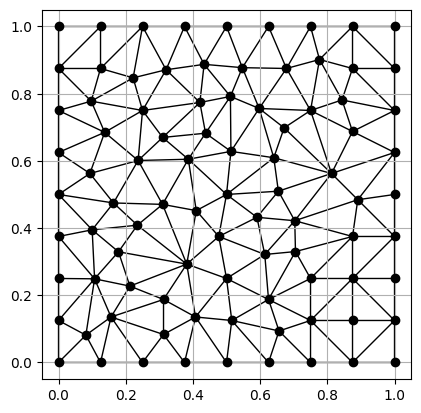

In [36]:
gedim.PlotMesh(mesh)

### Create Discrete Space FEM

The boundary condition types are passed to the library during the creation of the discrete space.
The types are the following:
* `BoundaryConditionType=1`: internal mesh point;
* `BoundaryConditionType=2`: strong boundary mesh point (Dirichlet in this example);
* `BoundaryConditionType=3`: weak boundary mesh point (Neumann in this example).
The array `BoundaryConditionType` describes for each `marker` the type of boundary condition associated.

__NB__: the array has dimension `num_markers+1`, as the first element is associated to non-usable `marker=0`.

__In this example__:

we have $3$ different markers, thus `BoundaryConditionsType` has size $3+1=4$. In particular `marker=1` has type `BoundaryConditionsType[1]=2` (Dirichlet), `marker=2` has type `BoundaryConditionsType[2]=3` and `marker=3` (Neumann) has type `BoundaryConditionsType[3]=3` (Neumann).

In [37]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

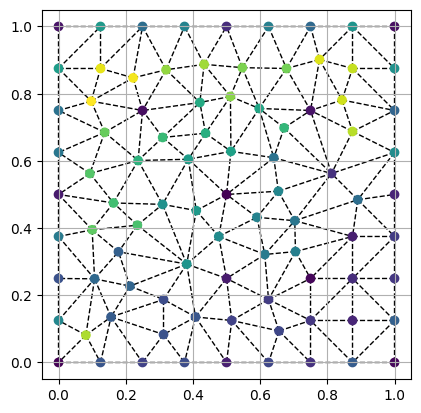

In [38]:
gedim.PlotDofs(mesh, dofs, strongs)

### Assemble linear system

In [39]:
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Poisson_a, problemData, lib)

[advection, advectionStrong] = gedim.AssembleAdvectionMatrix(Poisson_b, problemData, lib)

[reaction, reactionStrong] = gedim.AssembleReactionMatrix(Poisson_c, problemData, lib)

forcingTerm = gedim.AssembleForcingTerm(g, problemData, lib)

solutionStrong = gedim.AssembleStrongSolution(strongTerm, 1, problemData, lib)

### Solve linear system

In [40]:
solution = gedim.LUSolver(stiffness + advection + reaction, \
    forcingTerm - \
    (stiffnessStrong + advectionStrong + reactionStrong) @ solutionStrong, lib)

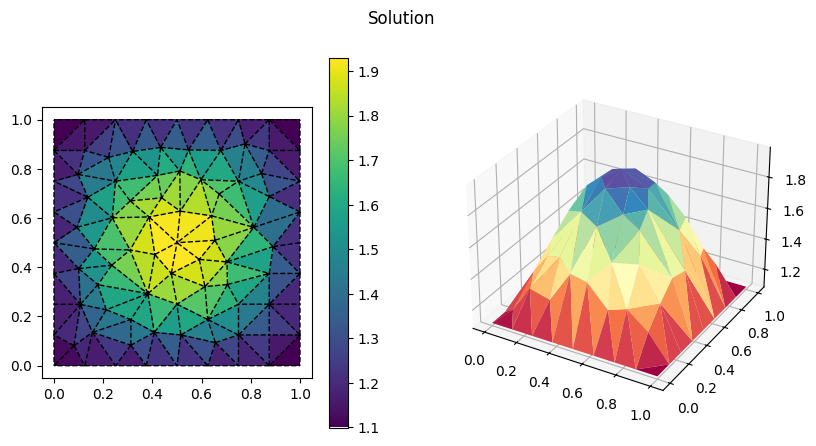

In [41]:
gedim.PlotSolution(mesh, dofs, strongs, solution, solutionStrong)

In [42]:
gedim.ExportSolution(exactSolution, solution, solutionStrong, lib)

### Compute errors

In [43]:
errorL2 = gedim.ComputeErrorL2(exactSolution, solution, solutionStrong, lib)

errorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, solution, solutionStrong, lib)

print("dofs", "h", "errorL2", "errorH1")
print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(errorL2), '{:.16e}'.format(errorH1))

dofs h errorL2 errorH1
57 2.0647876100132428e-01 1.0289217785994833e+00 5.3845940224553113e-01
